In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
%matplotlib inline

In [2]:
data = np.loadtxt("./lienard_intermittency.dat")

train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [4]:
train_dataloader = DataLoader(train_inout_seq, batch_size=10, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=10, shuffle=True, drop_last=True)

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250, nhead=10, num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())

        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        #print(output.size())
        
        output = self.decoder(output)
        #print(output.size())
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [37]:
model = TransAm(feature_size=250, nhead=10, num_layers=3,dropout=0.1).to('cuda')

In [38]:
from IPython.display import clear_output

In [39]:
input_window = 20

In [40]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [41]:
batch_size = 64

In [42]:
def run_epoch(train_data, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(x.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')

        out = model(data.to('cuda'))
        loss = criterion(out, targets.to('cuda'))

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

In [43]:
# def run_epoch(dataloader, is_training=False):
#     epoch_loss = 0

#     if is_training:
#         model.train()
#     else:
#         model.eval()

#     for idx, (x, y) in enumerate(dataloader):
#         if is_training:
#             optimizer.zero_grad()
            
#         #print(x.size())
#         #print(y.size())
#         x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
#         y = y.view(-1).float().to('cuda')
#         batchsize = x.shape[1]

#         out = model(x)
#         loss = criterion(out, y)

#         if is_training:
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
#             optimizer.step()

#         epoch_loss += (loss.detach().item() / batchsize)

#     #lr = scheduler.get_last_lr()[0]

#     return epoch_loss

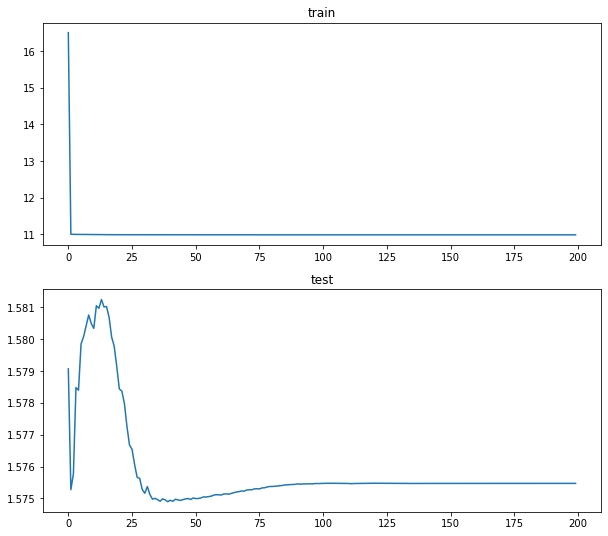

Epoch[200/200] | loss train:10.986583, test:1.575473


In [44]:
criterion = nn.MSELoss()
lr = 0.005 
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train = run_epoch(train_inout_seq, is_training=True)
    loss_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [14]:
#torch.save(model.state_dict(), 'bestTransformer')

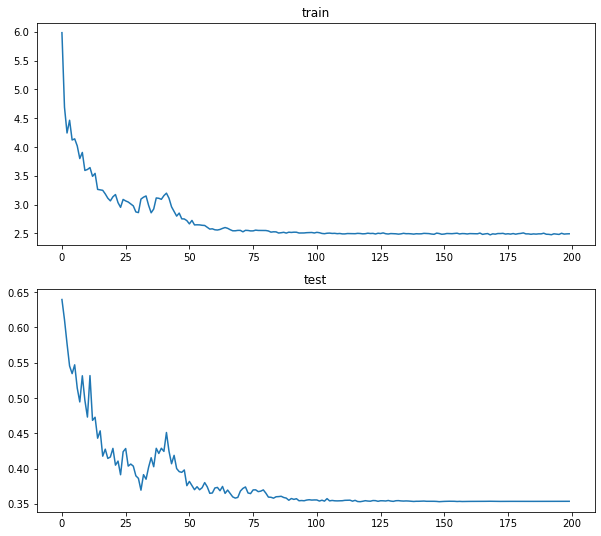

Epoch[200/200] | loss train:2.495003, test:0.353478


In [19]:
criterion = nn.MSELoss()
lr = 0.005 
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train = run_epoch(train_inout_seq, is_training=True)
    loss_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [13]:
model = TransAm().to('cuda')
model.load_state_dict(torch.load('transformer'))
model.eval()

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout

In [27]:
model = TransAm(feature_size=250, nhead=10, num_layers=2,dropout=0.1).to('cuda')
model.load_state_dict(torch.load('bestTransformer'))
model.eval()

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout

In [32]:
def ShowPredict(model1, k):
    #train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
    #val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    test_right_part = (len(test)- 20)%64
    predicted_val = np.array([])
    for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
        data, targets = get_batch(test_inout_seq, i,batch_size)
        if data.size()[1] < 64:
            break
        cur_x = data
        for _ in range(k):
            out = model1(cur_x.to('cuda'))
            #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
            cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
        #out = model1(cur_x.to('cuda'))
        #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
        predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
        
        
    if k == 1:
        r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
    else:
        r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
    print("RMSE is ", r)
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.set_title('k = {}'.format(k))
    ax_1.plot(test_norm[20+k-1:], label='true')
    if k == 1:
        ax_1.plot(predicted_val[:],  linestyle = '--', label='predicted')
    else:
        ax_1.plot(predicted_val[:-k+1],  linestyle = '--', label='predicted')
    ax_1.legend()
    
    
    plt.show()

RMSE is  0.1708790316647165


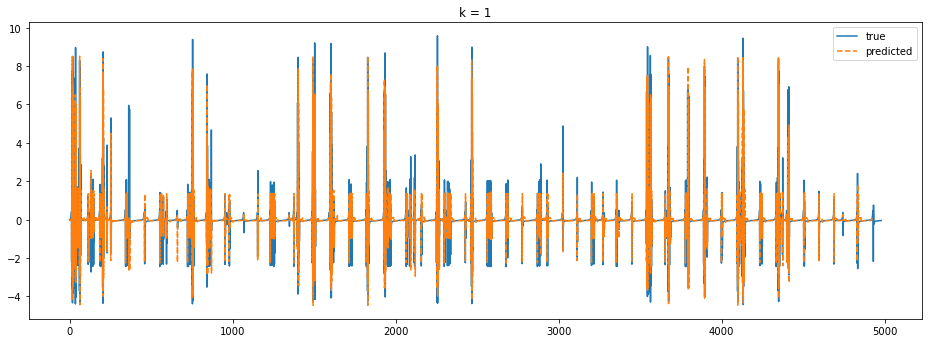

In [33]:
ShowPredict(model, 1)

RMSE is  0.33553812554799195


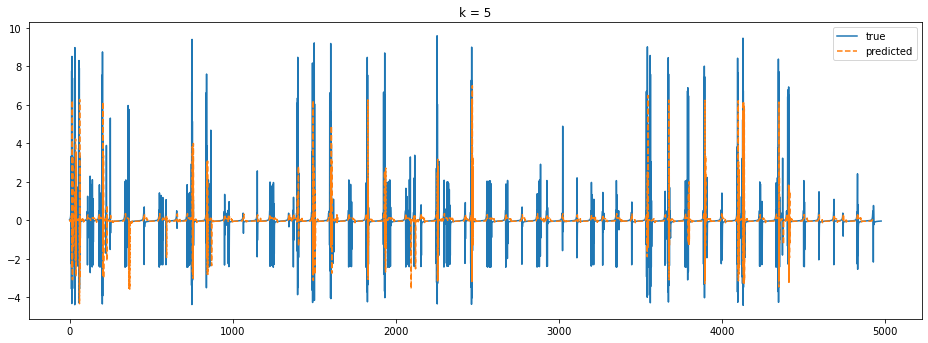

In [34]:
ShowPredict(model, 5)

RMSE is  0.34012110359812303


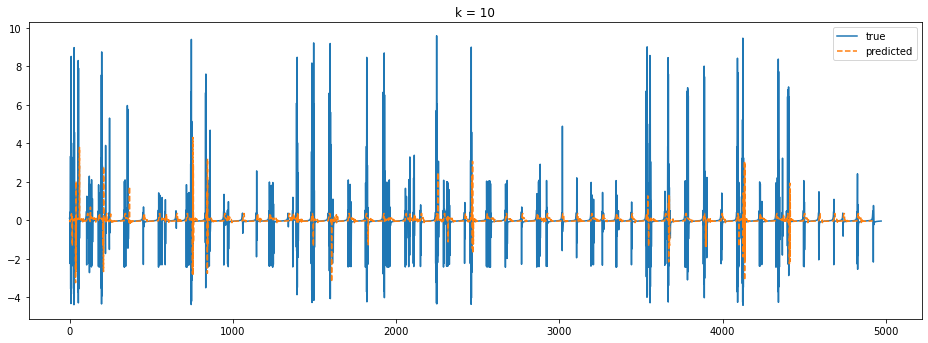

In [35]:
ShowPredict(model, 10)

RMSE is  0.3319687039139456


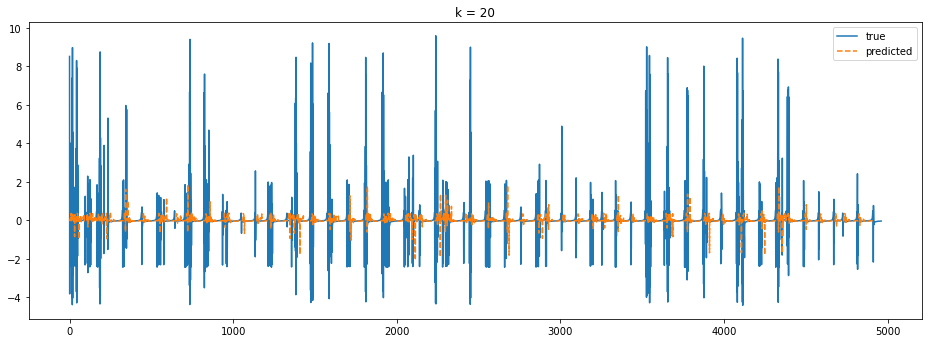

In [36]:
ShowPredict(model, 20)

RMSE is  0.4615440848724283


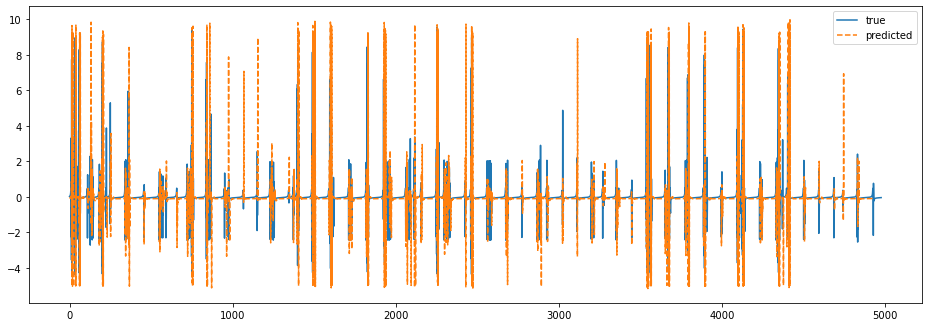

In [18]:
ShowPredict(model, 5)

In [11]:
def GetRmse(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []

    for k in range(1, 20):
        test_right_part = (len(test)- 20)%64
        predicted_val = np.array([])
        for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
            data, targets = get_batch(test_inout_seq, i,batch_size)
            if data.size()[1] < 64:
                break
            cur_x = data
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
                cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
            #out = model1(cur_x.to('cuda'))
            #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
            predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse

In [74]:
rmses = GetRmse(model, train_dataloader, test_dataloader, test, std, mean)

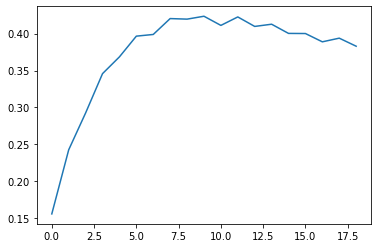

In [75]:
plt.plot(rmses)

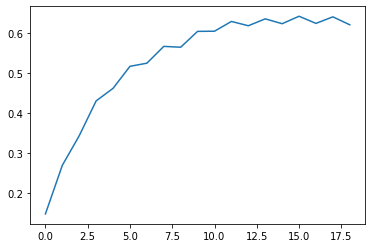

In [17]:
rmses = GetRmse(model, train_dataloader, test_dataloader, test, std, mean)
plt.plot(rmses)

# Подбор параметров

In [12]:
def run_epoch(model, train_data, optimizer, criterion, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(x.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')

        out = model(data.to('cuda'))
        loss = criterion(out, targets.to('cuda'))

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

In [13]:
def test_params(n_heads, feature_size, num_layers, dropout):  
    model = TransAm(feature_size=feature_size, nhead=n_heads, num_layers=num_layers,dropout=dropout).to('cuda')
    criterion = nn.MSELoss()
    lr = 0.005 
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

    losses_train = []
    losses_test = []
    # begin training
    epochs = 150
    for epoch in range(epochs):
        loss_train = run_epoch(model, train_inout_seq, optimizer, criterion,  is_training=True)
        loss_val = run_epoch(model, test_inout_seq, optimizer, criterion)
        scheduler.step()
        losses_train.append(loss_train)
        losses_test.append(loss_val)

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)
        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)
        plt.show()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}, n_heads:{}, feature_size:{}, num_layers:{}, dropout:{}'
                  .format(epoch+1, epochs, loss_train, loss_val, n_heads, feature_size, num_layers, dropout))
    rmses = GetRmse(model, train_dataloader, test_dataloader, test, std, mean)
    return rmses

In [14]:
parameteres = {"n_heads":[15, 20], "num_features": [300, 360, 420], "num_layers": [1, 2], "dropout": [0.1]}

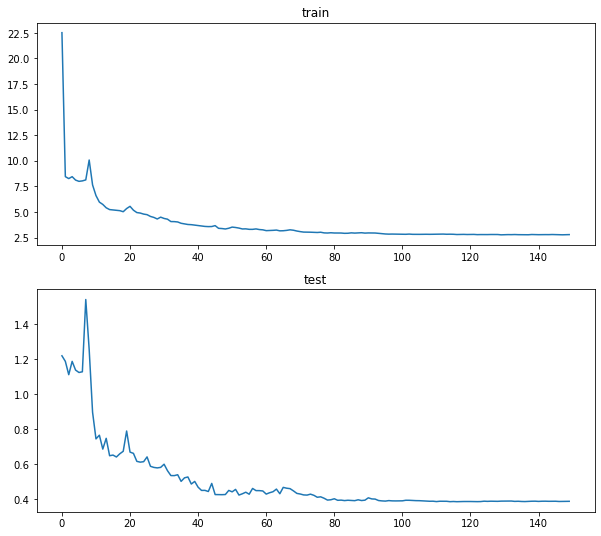

Epoch[150/150] | loss train:2.790426, test:0.386100, n_heads:20, feature_size:420, num_layers:2, dropout:0.1


In [15]:
res_params = []
for n_head in parameteres["n_heads"]:
    for num_f in parameteres["num_features"]:
        for n_layers in parameteres["num_layers"]:
            for dp in parameteres["dropout"]:
                rmses = test_params(n_head, num_f, n_layers, dp)
                res_params.append(["n_head", n_head, "num_features", num_f, "num_layers", n_layers, "dropout", dp, rmses])

In [16]:
res_params

[['n_head',
  15,
  'num_features',
  300,
  'num_layers',
  1,
  'dropout',
  0.1,
  [0.15945519038981015,
   0.2608062564684823,
   0.3327404661919851,
   0.38301582256285605,
   0.4145317842406704,
   0.4396351722204817,
   0.455703942591068,
   0.4737279441830005,
   0.47478429787798543,
   0.4857044366140051,
   0.48386784429826496,
   0.49205374897382553,
   0.4899914446532711,
   0.4977986257264334,
   0.4956091129204308,
   0.4970972874633005,
   0.5018926697436306,
   0.5035012788066814,
   0.5079285832570646]],
 ['n_head',
  15,
  'num_features',
  300,
  'num_layers',
  2,
  'dropout',
  0.1,
  [0.16932713132327953,
   0.26245802381919725,
   0.29620259806386173,
   0.34803524801437064,
   0.35132725006171084,
   0.3833754830250771,
   0.3791572861115138,
   0.3858560010490521,
   0.37932120165572775,
   0.3842193026454147,
   0.3780312355678824,
   0.37353973402700197,
   0.36853567744658255,
   0.36728940467998755,
   0.3624422026612007,
   0.36473929155043483,
   0.353796

In [16]:
res_params

[['n_head',
  15,
  'num_features',
  240,
  'num_layers',
  1,
  'dropout',
  0.1,
  [0.13808205427685002,
   0.24043255669193336,
   0.305301740439221,
   0.36181880501160824,
   0.3916854487594999,
   0.42722346325298693,
   0.44311877870140115,
   0.46559642723248906,
   0.466212310737067,
   0.4745941415812979,
   0.47209685394138157,
   0.4729028079537774,
   0.46153209434156683,
   0.46132205181228614,
   0.45025957264870997,
   0.45508388633967056,
   0.44400454349695867,
   0.44670691028165743,
   0.4387239021190568]],
 ['n_head',
  15,
  'num_features',
  240,
  'num_layers',
  2,
  'dropout',
  0.1,
  [0.17999303289219729,
   0.25541835423690273,
   0.31777741855211666,
   0.34607080067381335,
   0.37317238752007764,
   0.3968744108198355,
   0.4106143736467847,
   0.4231840309488673,
   0.42860774101689403,
   0.43035337488290515,
   0.42324580372360865,
   0.4248334651077144,
   0.42271176283294914,
   0.4193876159686437,
   0.41382255936804,
   0.40892487177287706,
   0.4

In [51]:
res_params

[['n_head',
  10,
  'num_features',
  350,
  'num_layers',
  1,
  'dropout',
  0.1,
  [0.14449806685697364,
   0.2513944784148641,
   0.32367924878545357,
   0.36977275768706247,
   0.3858579127439236,
   0.4334845176290479,
   0.4425718031629926,
   0.47328790473864324,
   0.46225746022870196,
   0.47850305494334777,
   0.46516435983545273,
   0.4749087328904219,
   0.46264593092614,
   0.4646658294402377,
   0.4517177244586588,
   0.458135161818645,
   0.4364654133645096,
   0.43478745645056655,
   0.41298498441890175]],
 ['n_head',
  10,
  'num_features',
  350,
  'num_layers',
  2,
  'dropout',
  0.1,
  [0.19429373923005888,
   0.29977813490672617,
   0.3211623214149114,
   0.35704712257357973,
   0.3642468222373784,
   0.38404521693380017,
   0.3894240733427249,
   0.3961264763427872,
   0.3924200682445433,
   0.3991496994695033,
   0.39102981044941054,
   0.3933343525447232,
   0.3859150135831895,
   0.3871853350598901,
   0.3760935867364959,
   0.3781472279989915,
   0.371225549

In [48]:
res_params

[['n_head',
  10,
  'num_features',
  250,
  'num_layers',
  1,
  'dropout',
  0.1,
  [0.13575263726462233,
   0.23777560219075977,
   0.286690876902121,
   0.33493214194478166,
   0.35785801596876465,
   0.3831628496182629,
   0.38938519973223096,
   0.4032812250750121,
   0.4070214776499043,
   0.41160333254971265,
   0.41006974348829944,
   0.40953470733076697,
   0.40640958056387494,
   0.40192801436071657,
   0.3936378552456053,
   0.39059501083060005,
   0.3805507642190888,
   0.38308727442488605,
   0.37800981948530077]],
 ['n_head',
  10,
  'num_features',
  250,
  'num_layers',
  1,
  'dropout',
  0.2,
  [0.16890005932312482,
   0.2722628951842476,
   0.34910841534976544,
   0.39085018332917465,
   0.4259031545681192,
   0.447655336363605,
   0.47382303906103257,
   0.4786456132391527,
   0.4959507954028724,
   0.4900482560384643,
   0.5057679641887776,
   0.4926298513088818,
   0.5043713142232624,
   0.4917048404992437,
   0.5043860549831326,
   0.48893619788935444,
   0.4995

In [ ]:
rmses = []

RMSE is  0.33168155984700204


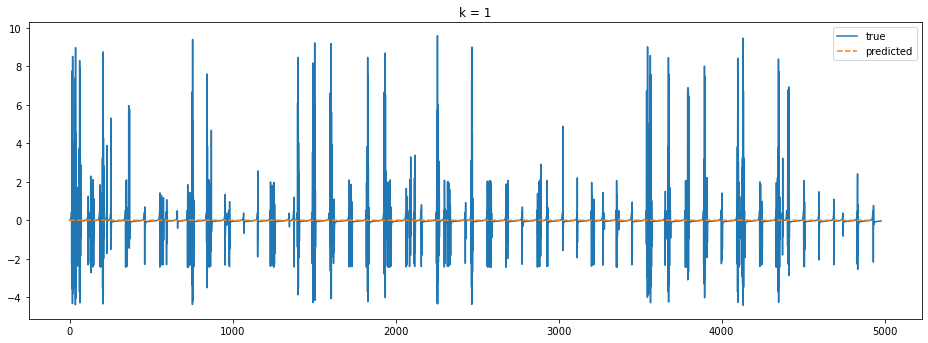

In [45]:
ShowPredict(model, 1)

In [ ]:
rmses.append([0.13575263726462233,
   0.23777560219075977,
   0.286690876902121,
   0.33493214194478166,
   0.35785801596876465,
   0.3831628496182629,
   0.38938519973223096,
   0.4032812250750121,
   0.4070214776499043,
   0.41160333254971265,
   0.41006974348829944,
   0.40953470733076697,
   0.40640958056387494,
   0.40192801436071657,
   0.3936378552456053,
   0.39059501083060005,
   0.3805507642190888,
   0.38308727442488605,
   0.37800981948530077])

rmses.append([0.16890005932312482,
   0.2722628951842476,
   0.34910841534976544,
   0.39085018332917465,
   0.4259031545681192,
   0.447655336363605,
   0.47382303906103257,
   0.4786456132391527,
   0.4959507954028724,
   0.4900482560384643,
   0.5057679641887776,
   0.4926298513088818,
   0.5043713142232624,
   0.4917048404992437,
   0.5043860549831326,
   0.48893619788935444,
   0.4995193660013158,
   0.4861335482053811,
   0.49423109831471035])

rmses.append([0.17722219913772952,
   0.2644036576268369,
   0.2886687045221142,
   0.31354798036895265,
   0.3276554682709834,
   0.34856580129068815,
   0.3455423443849975,
   0.34213511962144993,
   0.3340378903933461,
   0.33636021230150304,
   0.3322118386184471,
   0.3330597575635417,
   0.33193096700607144,
   0.33471017946831366,
   0.33332489841516777,
   0.33322437001160465,
   0.33333825832508046,
   0.3319206486489431,
   0.33027776006845155])

rmses.append([0.20435678930839862,
   0.2925024005695067,
   0.3332760747298744,
   0.378647208818273,
   0.3987888429376986,
   0.42521829329735344,
   0.42966501007987573,
   0.4428251361033973,
   0.42639972961252975,
   0.4349040982536559,
   0.41591687746728806,
   0.4274975274407723,
   0.4069539488152021,
   0.41211642261770975,
   0.39146914110922776,
   0.3964505665410463,
   0.37549014372045114,
   0.3765912914692246,
   0.35736639404357945])

rmses.append([0.33167869893120505,
   0.3317123563337903,
   0.33174602412199133,
   0.33177970121529016,
   0.3318133858688619,
   0.3318470752015404,
   0.33188076426363866,
   0.3319144443737076,
   0.3319480993147426,
   0.33198169666057015,
   0.3320151650209923,
   0.33204832454516414,
   0.33208062642913133,
   0.33210994230837076,
   0.3320129008951225,
   0.33204474092688363,
   0.33179290213563706,
   0.33149732726902875,
   0.32996832543146376])

rmses.append([0.14729972829618918,
   0.25758417301976644,
   0.3199343349158229,
   0.3684292227835557,
   0.3949490351337913,
   0.4200060517391637,
   0.4370988289171613,
   0.45247445279202886,
   0.4619734784528797,
   0.4606177811255205,
   0.4639753557050247,
   0.45968148274373116,
   0.46380361318557095,
   0.4560573555201856,
   0.4565453133493473,
   0.44534558773287425,
   0.44880820355931045,
   0.43501303906368605,
   0.4342853958392138])

rmses.append([0.16341754417211532,
   0.2730525923570621,
   0.34294734663370036,
   0.38309772304025247,
   0.4230416569894848,
   0.451537750938602,
   0.482118406678455,
   0.49275650771591667,
   0.5071936440683337,
   0.5100797135643171,
   0.5213662326497636,
   0.5198109497101666,
   0.5262532629213215,
   0.5190276985647024,
   0.5258471508004251,
   0.5205118039650246,
   0.5287205866416415,
   0.5238985601453232,
   0.5312036510286192])

rmses.append([0.17786906095747362,
   0.2699593277762066,
   0.30128988590510547,
   0.3301239439752216,
   0.3426304546884241,
   0.37440742702996227,
   0.371823829413522,
   0.37932425496721356,
   0.37333294066945777,
   0.36376539054369,
   0.36128805481578435,
   0.34952100274951076,
   0.3449318102528066,
   0.3437865656793781,
   0.3445978234537984,
   0.3417657598430146,
   0.33840222506868955,
   0.339599452304531,
   0.3399690563451628])

rmses.append([0.19741532250797375,
   0.30351998591938434,
   0.3362170332823161,
   0.3928281515294461,
   0.40521323624622474,
   0.43971426905795274,
   0.4499264699280058,
   0.4597143635498465,
   0.4714132622761779,
   0.4653260369365347,
   0.4774967957531582,
   0.45794213705084313,
   0.4677599671877153,
   0.4457890025596725,
   0.4522844954311025,
   0.428338890979184,
   0.4313256025961985,
   0.41075045857027853,
   0.4156978202898311])

rmses.append([0.14449806685697364,
   0.2513944784148641,
   0.32367924878545357,
   0.36977275768706247,
   0.3858579127439236,
   0.4334845176290479,
   0.4425718031629926,
   0.47328790473864324,
   0.46225746022870196,
   0.47850305494334777,
   0.46516435983545273,
   0.4749087328904219,
   0.46264593092614,
   0.4646658294402377,
   0.4517177244586588,
   0.458135161818645,
   0.4364654133645096,
   0.43478745645056655,
   0.41298498441890175])

rmses.append([0.19429373923005888,
   0.29977813490672617,
   0.3211623214149114,
   0.35704712257357973,
   0.3642468222373784,
   0.38404521693380017,
   0.3894240733427249,
   0.3961264763427872,
   0.3924200682445433,
   0.3991496994695033,
   0.39102981044941054,
   0.3933343525447232,
   0.3859150135831895,
   0.3871853350598901,
   0.3760935867364959,
   0.3781472279989915,
   0.37122554966619714,
   0.37549639865800666,
   0.3747593613157008])

rmses.append([0.15074817776063887,
   0.2554671576145253,
   0.31483729133277866,
   0.3670980744186067,
   0.40048706818847746,
   0.4351716525627933,
   0.451112399715957,
   0.4705548968626949,
   0.4796726262846169,
   0.4823412578789096,
   0.4926882758492929,
   0.49032374671102585,
   0.49685255184852395,
   0.48741610748568526,
   0.49350526533838074,
   0.48792592614444413,
   0.4879787890058897,
   0.48521422143429527,
   0.4855813840061179])

rmses.append([0.18405599835559638,
   0.2682115402070324,
   0.30297612131062324,
   0.32064053287964517,
   0.3428881057787508,
   0.36011840575140713,
   0.3742762039909863,
   0.3797144648296711,
   0.3867270301008323,
   0.386541350234264,
   0.38919469452014194,
   0.38461799092664684,
   0.381567946541908,
   0.3735209257567446,
   0.3681996871773305,
   0.36285322222345157,
   0.35870162241530323,
   0.3507015179200243,
   0.3467279983293704])

rmses.append([0.13808205427685002,
   0.24043255669193336,
   0.305301740439221,
   0.36181880501160824,
   0.3916854487594999,
   0.42722346325298693,
   0.44311877870140115,
   0.46559642723248906,
   0.466212310737067,
   0.4745941415812979,
   0.47209685394138157,
   0.4729028079537774,
   0.46153209434156683,
   0.46132205181228614,
   0.45025957264870997,
   0.45508388633967056,
   0.44400454349695867,
   0.44670691028165743,
   0.4387239021190568])

rmses.append([0.17999303289219729,
   0.25541835423690273,
   0.31777741855211666,
   0.34607080067381335,
   0.37317238752007764,
   0.3968744108198355,
   0.4106143736467847,
   0.4231840309488673,
   0.42860774101689403,
   0.43035337488290515,
   0.42324580372360865,
   0.4248334651077144,
   0.42271176283294914,
   0.4193876159686437,
   0.41382255936804,
   0.40892487177287706,
   0.40130265599622134,
   0.3859342173544871,
   0.37897551966304244])

rmses.append([0.16932713132327953,
   0.26245802381919725,
   0.29620259806386173,
   0.34803524801437064,
   0.35132725006171084,
   0.3833754830250771,
   0.3791572861115138,
   0.3858560010490521,
   0.37932120165572775,
   0.3842193026454147,
   0.3780312355678824,
   0.37353973402700197,
   0.36853567744658255,
   0.36728940467998755,
   0.3624422026612007,
   0.36473929155043483,
   0.3537962597811126,
   0.35307769179439824,
   0.34299265687086694])

rmses.append([0.1451293052176298,
   0.2512094242673628,
   0.3258039185911415,
   0.3680710881108944,
   0.3958007944609236,
   0.4362205305210588,
   0.45065447602228226,
   0.4710926842278757,
   0.46531736389782896,
   0.4802489459717115,
   0.4788747665287969,
   0.4883682394673023,
   0.4822405954601462,
   0.48531414017993124,
   0.4792689142074106,
   0.4867949991772827,
   0.47805602071199155,
   0.48277452456658265,
   0.47294030509875434])

rmses.append([0.16187339116514374,
   0.2603417420077404,
   0.29669224211285095,
   0.326221442090238,
   0.3529140907441385,
   0.3821110935589541,
   0.39547554125794243,
   0.3988942901022562,
   0.4026231846553311,
   0.4034109704239358,
   0.3978510666128401,
   0.3963571676646671,
   0.40072243534307755,
   0.4129180437277141,
   0.38461032672367773,
   0.4077664725557988,
   0.4133642925864334,
   0.48928543905537575,
   0.41018708464672143])

rmses.append([0.14024299221438224,
   0.23700493546503518,
   0.3057221964056488,
   0.3501503670981086,
   0.38302323808023386,
   0.4176959230994623,
   0.43239405975516954,
   0.44928932426501916,
   0.4522303813388348,
   0.45471376187977985,
   0.4557800016951488,
   0.44931308791784497,
   0.45113868314809435,
   0.4463729280043173,
   0.44658849371488224,
   0.4379021826873259,
   0.44372109913771934,
   0.424167376336144,
   0.43142301187572407])

rmses.append([0.17010969250465496,
   0.2589708454189078,
   0.317325278841174,
   0.3615361401953938,
   0.38497895586281117,
   0.40365360052813865,
   0.4203469303158363,
   0.4320258291659347,
   0.42886275813313657,
   0.42703169484721537,
   0.42608949798692763,
   0.4238555815901507,
   0.41844540975762423,
   0.4165464948296055,
   0.40546369971756135,
   0.41026166622750654,
   0.39736085638879104,
   0.399961518991626,
   0.3827445572883278])

rmses.append([0.15417461629255672,
   0.24176599091717332,
   0.30097220831352467,
   0.3588083244709024,
   0.3742699077469855,
   0.3954858878614077,
   0.4041154381247216,
   0.3967684964460229,
   0.4041661307618639,
   0.40323974846619626,
   0.4080616436960827,
   0.4010690182059952,
   0.3971927199850488,
   0.38777941142709843,
   0.387209643189277,
   0.3803801264712414,
   0.3757280883271909,
   0.3598288348346012,
   0.3506531228547679])

rmses.append([0.14387335834225043,
   0.2500745981745652,
   0.32261931737031757,
   0.3714259426435783,
   0.39331261121943517,
   0.42522615175066647,
   0.445633708095488,
   0.46393030345519914,
   0.4640712571626224,
   0.4684364647857084,
   0.4729309561733783,
   0.47096821604097244,
   0.47124759085910495,
   0.46945332550714186,
   0.46780575296780397,
   0.4638937868023867,
   0.4636693186476552,
   0.4587341007112398,
   0.4583615727028617])

rmses.append([0.16039138100060443,
   0.2629781381000964,
   0.2908967283716822,
   0.31638917049510706,
   0.3357967509425068,
   0.3627630883515847,
   0.37847922037654086,
   0.38292959069819105,
   0.3777723051266747,
   0.3717661410691985,
   0.37221665257188685,
   0.3658686533511494,
   0.36223017853207723,
   0.36958798910531643,
   0.3611606179656157,
   0.3647453140340435,
   0.3591307173901977,
   0.3566301325415744,
   0.3551477571067706])

rmses.append([0.14252257109424601,
   0.2522113570903269,
   0.3189662742813396,
   0.38105804926751985,
   0.3987051089830472,
   0.43134336678257706,
   0.4342041422380917,
   0.4601389835048923,
   0.4549722757354628,
   0.4760109294237088,
   0.46446667986676776,
   0.4799519335139353,
   0.46671443883838715,
   0.47053914197353536,
   0.45564460198667206,
   0.45886183000386954,
   0.4454313817319844,
   0.4423854861317253,
   0.4357061499397648])

rmses.append([0.17116535022184037,
   0.26806875347083564,
   0.3065601514487543,
   0.34095974341828067,
   0.3686696853003467,
   0.3988623722395356,
   0.4105504371965596,
   0.4175066077242144,
   0.4160048229481613,
   0.42051099490650323,
   0.41774555856356527,
   0.41619876668932115,
   0.4173500699561827,
   0.41365989714132195,
   0.41432107181306516,
   0.40254074142919805,
   0.39501865558816524,
   0.3752669874820751,
   0.3634404463543878])

lstm_rmse = [0.04757317137635775,
 0.1066439033044791,
 0.16165334959874902,
 0.23547535034939132,
 0.2715069030985893,
 0.326520906213535,
 0.3603018786967133,
 0.400559221266473,
 0.4125430306735424,
 0.44108091249041215,
 0.4441149681218204,
 0.44102895535200537,
 0.44894547900754833,
 0.4376582260897111,
 0.45034317893695813,
 0.4428517115863715,
 0.4577106328800195,
 0.46194935804636356,
 0.46403083650016536]

